<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/geolocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geolocation prediction of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using language modelling and text classification to geolocate proverbs whose information is not known.
---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import ast

In [2]:
balanced_corpus = pd.read_csv("data/balanced_corpus.csv", index_col=0)
 # quality assurance patch
geolocs = pd.read_csv('data/geolocs.csv')
balanced_corpus.lat = balanced_corpus.area.apply(lambda x: geolocs[x].iloc[0])
balanced_corpus.lon = balanced_corpus.area.apply(lambda x: geolocs[x].iloc[1])

balanced_corpus

,text,place,uri,collector,area,lat,lon
105697,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,39.650192,20.690846
8413,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,39.650192,20.690846
7684,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,39.650192,20.690846
18546,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,39.650192,20.690846
94001,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,39.650192,20.690846
...,...,...,...,...,...,...,...
101735,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
101233,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
101612,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
101762,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477


In [3]:
train, test = train_test_split(balanced_corpus, 
                               test_size=0.05, 
                               random_state=2023)
train, dev = train_test_split(train, 
                              test_size=test.shape[0], 
                              random_state=2023)

## Authorship analysis


In [4]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

* Training one language model per area, by sampling proverbs of that area

In [5]:
# building the local language models
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[loc_name[area]] = LM(gram="CHAR").train(" \n ".join(texts))

In [6]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {loc:[models[loc].cross_entropy(proverb.lower())] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [7]:
# use case
loc, dists = ling_dist('κακόν χωριόν τσα λίγα σπίτιαν')
dists.sort_values(by=0, ascending=True, axis=1)

,Asia Minor,Ioannina,Karpathos,Crete,Thesprotia,Epirus,Kefalinia,Amorgos,Eptanisos,Cyprus,...,Achaia,Arcadia,Etolia,Pontos,Skyros,East Thrace,Thrace,Maced.,Naxos,Lesvos
0,4.038577,4.313742,4.318077,4.4117,4.430579,4.492731,4.538359,4.863242,5.019258,5.063717,...,5.119214,5.133526,5.15317,5.18501,5.243022,5.250783,5.424325,5.457056,5.671837,6.209453


In [8]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Πωρνόσ στησ στράταν, τζ' ενωρίς στο κονατζιν (Κύπρος) -- predicted as: Cyprus


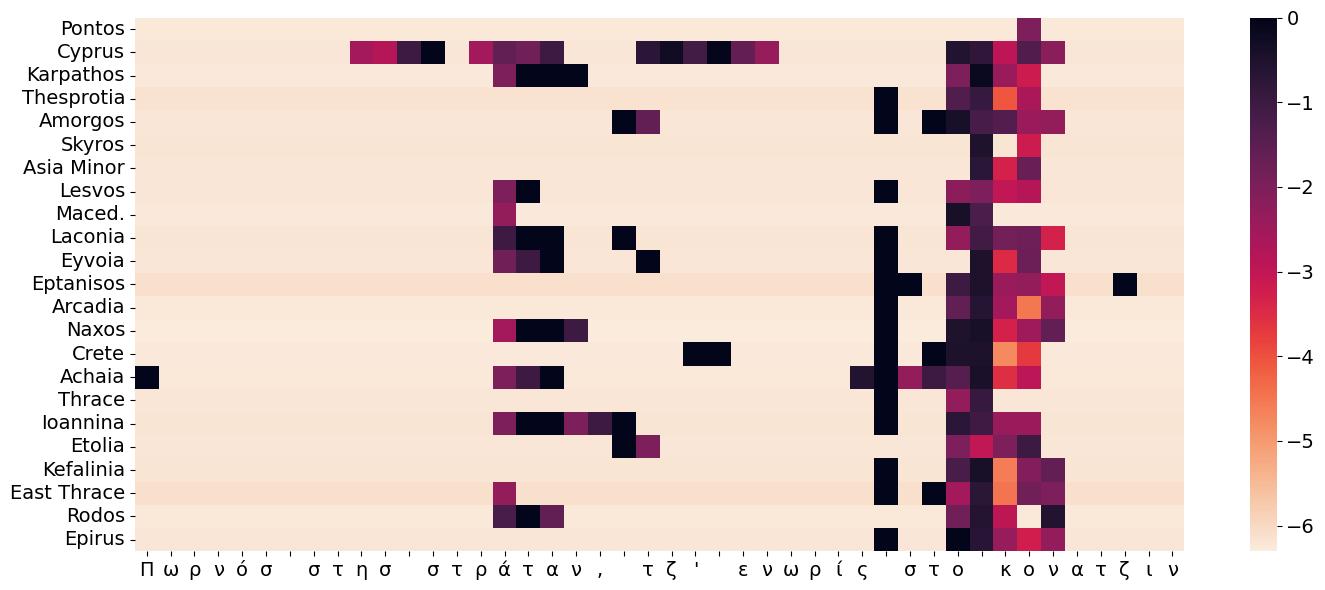

In [9]:
t = test[(test.area == "Κύπρος") & test.text.str.startswith('Πωρνό')].iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
plt.tick_params(axis='both', which='major', labelsize=14)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
ax.figure.tight_layout()
ax.figure.savefig("heatmap.pdf", format="PDF")

* Evaluating on unseen proverbs

In [10]:
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
gold = test.area.apply(lambda x: loc_name[x]).values
print(classification_report(gold, predictions, zero_division=0))

              precision    recall  f1-score   support

      Achaia       0.14      0.12      0.13        32
     Amorgos       0.19      0.14      0.16        22
     Arcadia       0.08      0.06      0.07        31
  Asia Minor       0.17      0.17      0.17        18
       Crete       0.23      0.23      0.23        30
      Cyprus       0.73      0.79      0.76        24
 East Thrace       0.12      0.17      0.14        24
      Epirus       0.11      0.13      0.12        23
   Eptanisos       0.25      0.35      0.29        23
      Etolia       0.40      0.33      0.36        24
      Eyvoia       0.07      0.15      0.10        20
    Ioannina       0.17      0.14      0.15        29
   Karpathos       0.37      0.25      0.30        28
   Kefalinia       0.11      0.15      0.13        27
     Laconia       0.04      0.04      0.04        27
      Lesvos       0.45      0.38      0.41        24
      Maced.       0.19      0.19      0.19        27
       Naxos       0.34    

* The confusion matrix can inform us about the confusion in the predictions

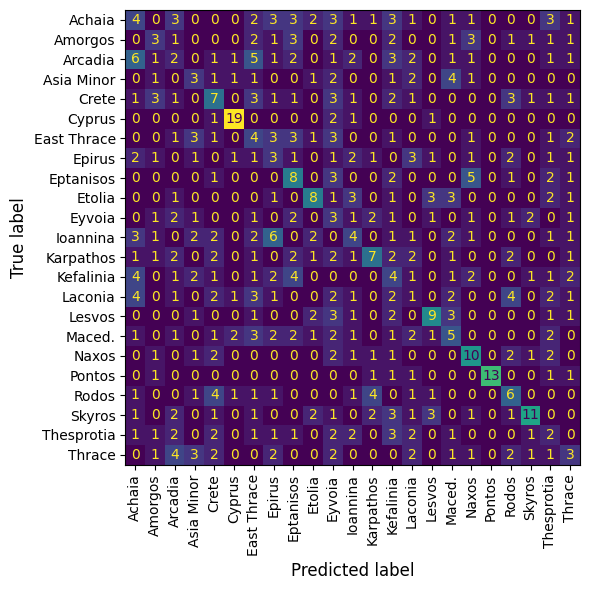

In [11]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(gold, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

## Benchmarking Standard Text Classifiers on Top of Character n-grams

In [12]:
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
print('Vocabulary:', len(vect.vocabulary_))
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

Vocabulary: 81402
n-gram: "ία" 	(tfidf: 0.21)
n-gram: "αρ" 	(tfidf: 0.12)
n-gram: "αρο" 	(tfidf: 0.21)
n-gram: "αροι" 	(tfidf: 0.37)
n-gram: "ιμ" 	(tfidf: 0.19)
n-gram: "ιμί" 	(tfidf: 0.33)
n-gram: "ιμία" 	(tfidf: 0.38)
n-gram: "μί" 	(tfidf: 0.21)
n-gram: "μία" 	(tfidf: 0.30)
n-gram: "οι" 	(tfidf: 0.13)
n-gram: "οιμ" 	(tfidf: 0.28)
n-gram: "πα" 	(tfidf: 0.11)
n-gram: "παρ" 	(tfidf: 0.18)
n-gram: "παρο" 	(tfidf: 0.36)
n-gram: "ρο" 	(tfidf: 0.12)
n-gram: "ροι" 	(tfidf: 0.26)


### Logistic Regression

In [13]:
vect = TfidfVectorizer(ngram_range=(2, 5), 
                       analyzer="char",
                       max_df=0.5, 
                       min_df=2, lowercase=True)

regressor = LogisticRegression()

pipe = Pipeline([('vect', vect), ('ref', regressor)])

scores = cross_val_score(pipe,
                         train.text.values,
                         train.area.values,
                         cv=5,
                         n_jobs=-1)

cv_score = scores.mean()
print(cv_score)

pipe = Pipeline([('vect', vect), ('clf', LogisticRegression())])
pipe.fit(train.text, train.area)
preds = pipe.predict(test.text)
print(f'LogisticRegression\n{classification_report(test.area.values, preds)}')

0.2859903381642512
LogisticRegression
                 precision    recall  f1-score   support

        Ήπειρος       0.17      0.17      0.17        23
        Αιτωλία       0.38      0.58      0.46        24
        Αμοργός       0.13      0.18      0.15        22
Ανατολική Θράκη       0.16      0.21      0.18        24
        Αρκαδία       0.20      0.16      0.18        31
          Αχαΐα       0.39      0.22      0.28        32
      Επτάνησος       0.35      0.65      0.45        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.05      0.05      0.05        22
          Θράκη       0.25      0.16      0.20        25
       Ιωάννινα       0.29      0.21      0.24        29
       Κάρπαθος       0.40      0.29      0.33        28
     Κεφαλληνία       0.14      0.11      0.12        27
          Κρήτη       0.35      0.27      0.30        30
         Κύπρος       0.72      0.75      0.73        24
         Λέσβος       0.42      0.62      0.50   

### SVM

In [14]:
def objective(trial):

    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    classifier = LinearSVC(C=C, penalty=penalty, dual=False, max_iter=5000)

    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             train.area,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-08 10:52:21,877] A new study created in memory with name: no-name-b9f7362c-2764-4d4c-bfe3-9adea5fa0926


[I 2024-11-08 10:52:24,661] Trial 4 finished with value: 0.1077294685990338 and parameters: {'C': 4.4189487431515554e-07, 'penalty': 'l2'}. Best is trial 4 with value: 0.1077294685990338.
[I 2024-11-08 10:52:24,988] Trial 10 finished with value: 0.0442512077294686 and parameters: {'C': 0.0002948631763625472, 'penalty': 'l1'}. Best is trial 4 with value: 0.1077294685990338.
[I 2024-11-08 10:53:40,292] Trial 12 finished with value: 0.17043478260869566 and parameters: {'C': 9583223.429540787, 'penalty': 'l1'}. Best is trial 12 with value: 0.17043478260869566.
/Users/panos/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2024-11-08 10:53:46,153] Trial 1 finished with value: 0.2603864734299517 and parameters: {'C': 6.7171198174551, 'penalty': 'l1'}. Best is trial 1 with value: 0.2603864734299517.
/Users/panos/.pyenv/versions/3.12.7/lib/python3.12/site-packag

In [15]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.30135265700483094
best trial: FrozenTrial(number=50, state=1, values=[0.30135265700483094], datetime_start=datetime.datetime(2024, 11, 8, 11, 0, 10, 974666), datetime_complete=datetime.datetime(2024, 11, 8, 11, 1, 13, 245131), params={'C': 0.28113800529204847, 'penalty': 'l2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None), 'penalty': CategoricalDistribution(choices=('l1', 'l2'))}, trial_id=50, value=None)
best params: {'C': 0.28113800529204847, 'penalty': 'l2'}


In [16]:
classifier = LinearSVC(**best_params,  dual=False, max_iter=5000)
predictor_clf = Pipeline([('vect', vect), ('clf', LinearSVC())]) 
predictor_clf.fit(train.text.values, train.area.values) 
predictions_clf = predictor_clf.predict(test.text.values) 
print(classification_report(test.area.values, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10    

### KNN

In [17]:
# For some reason, scikit-learn will not always
# encode 'Ήπειρος'. This is a workaround.
from sklearn.preprocessing import LabelEncoder

area_encoded = LabelEncoder().fit_transform(train.area)

def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors,
                                      weights=weights,
                                      p=p)

    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             area_encoded,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-08 11:06:53,988] A new study created in memory with name: no-name-7cc67f4e-d75b-43d2-a82d-0755f4fc6177
[I 2024-11-08 11:06:56,354] Trial 8 finished with value: 0.21594202898550724 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'p': 2}. Best is trial 8 with value: 0.21594202898550724.
[I 2024-11-08 11:06:56,558] Trial 1 finished with value: 0.19971014492753625 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'p': 2}. Best is trial 8 with value: 0.21594202898550724.
[I 2024-11-08 11:06:56,675] Trial 0 finished with value: 0.2094685990338164 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'p': 2}. Best is trial 8 with value: 0.21594202898550724.
[I 2024-11-08 11:06:58,714] Trial 6 finished with value: 0.19971014492753625 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 8 with value: 0.21594202898550724.
[I 2024-11-08 11:06:59,225] Trial 5 finished with value: 0.18309178743961355 and parameters: {'n_neighbors': 6, 

In [18]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.21594202898550724
best trial: FrozenTrial(number=8, state=1, values=[0.21594202898550724], datetime_start=datetime.datetime(2024, 11, 8, 11, 6, 54, 5999), datetime_complete=datetime.datetime(2024, 11, 8, 11, 6, 56, 353703), params={'n_neighbors': 50, 'weights': 'distance', 'p': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=50, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2))}, trial_id=8, value=None)
best params: {'n_neighbors': 50, 'weights': 'distance', 'p': 2}


In [19]:
classifier = KNeighborsClassifier(**best_params)
pipe = Pipeline([('vect', vect), ('clf', classifier)])
pipe.fit(train.text, train.area)
score = pipe.score(test.text, test.area)
score

0.24347826086956523

In [20]:
predictor_clf = Pipeline([('vect', vect), ('clf', classifier)])
predictor_clf.fit(train.text, train.area)
predictions_clf = predictor_clf.predict(test.text)
print(classification_report(test.area, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.05      0.04      0.05        23
        Αιτωλία       0.27      0.29      0.28        24
        Αμοργός       0.21      0.27      0.24        22
Ανατολική Θράκη       0.14      0.21      0.17        24
        Αρκαδία       0.08      0.06      0.07        31
          Αχαΐα       0.21      0.19      0.20        32
      Επτάνησος       0.28      0.57      0.37        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.09      0.09      0.09        22
          Θράκη       0.19      0.12      0.15        25
       Ιωάννινα       0.13      0.07      0.09        29
       Κάρπαθος       0.33      0.21      0.26        28
     Κεφαλληνία       0.16      0.19      0.17        27
          Κρήτη       0.26      0.20      0.23        30
         Κύπρος       0.52      0.71      0.60        24
         Λέσβος       0.37      0.46      0.41        24
        Λακωνία       0.11    

### Random Forest

In [21]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    classifier = RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             train.area,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-08 11:08:47,785] A new study created in memory with name: no-name-63a96918-eff6-44d9-b34a-85f3e26abe12
[I 2024-11-08 11:08:51,957] Trial 7 finished with value: 0.18637681159420288 and parameters: {'n_estimators': 156, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.18637681159420288.
[I 2024-11-08 11:08:52,550] Trial 4 finished with value: 0.22888888888888886 and parameters: {'n_estimators': 220, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.22888888888888886.
[I 2024-11-08 11:08:52,606] Trial 1 finished with value: 0.22415458937198068 and parameters: {'n_estimators': 258, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.22888888888888886.
[I 2024-11-08 11:08:53,219] Trial 5 finished with value: 0.23526570048309176 and parameters: {'n_estimators': 441, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 5 with

In [22]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.24666666666666667
best trial: FrozenTrial(number=72, state=1, values=[0.24666666666666667], datetime_start=datetime.datetime(2024, 11, 8, 11, 10, 6, 712998), datetime_complete=datetime.datetime(2024, 11, 8, 11, 10, 37, 621117), params={'n_estimators': 428, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=72, value=None)
best params: {'n_estimators': 428, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 2}


In [23]:
classifier = RandomForestClassifier(**best_params)
pipe = Pipeline([('vect', vect), ('clf', classifier)])
pipe.fit(train.text, train.area)
score = pipe.score(test.text, test.area)
score

0.29739130434782607

In [24]:
predictor_clf = Pipeline([('vect', vect), ('clf', classifier)])
predictor_clf.fit(train.text, train.area)
predictions_clf = predictor_clf.predict(test.text)
print(classification_report(test.area, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.20      0.04      0.07        23
        Αιτωλία       0.29      0.62      0.40        24
        Αμοργός       0.07      0.14      0.10        22
Ανατολική Θράκη       0.16      0.25      0.19        24
        Αρκαδία       0.12      0.13      0.13        31
          Αχαΐα       0.59      0.31      0.41        32
      Επτάνησος       0.27      0.35      0.30        23
         Εύβοια       0.00      0.00      0.00        20
      Θεσπρωτία       0.18      0.14      0.15        22
          Θράκη       0.40      0.16      0.23        25
       Ιωάννινα       0.16      0.14      0.15        29
       Κάρπαθος       0.64      0.25      0.36        28
     Κεφαλληνία       0.26      0.22      0.24        27
          Κρήτη       0.40      0.27      0.32        30
         Κύπρος       0.51      0.79      0.62        24
         Λέσβος       0.38      0.62      0.48        24
        Λακωνία       0.19    

## Predicting the Location of Proverbs Based on Words

* Focusing on ones which are shared in multiple locations

In [25]:
duplicates = pd.read_csv('data/duplicates_geolocated.csv')
duplicates['place'] = duplicates['place'].apply(ast.literal_eval)
duplicates['area'] = duplicates['area'].apply(ast.literal_eval)
duplicates

,text,place,place_num,area,area_num,latlon
0,(Ε)πήρε βάγια,"{Λακωνία, Ήπειρος}",2,"{Λακωνία, Ήπειρος}",2,"[(36.76027945, 22.79046431389755), (39.6501917..."
1,"Άβολος ο νους, διπλός ο κόπος","{Μικρά Ασία>Τσεσμές (Κρήνη), Νίσυρος}",2,"{Νίσυρος, Μικρά Ασία}",2,"[(38.1846366, 23.5122768), (36.58904575, 27.16..."
2,Άβουλος νους διπλός κόπος,"{Θράκη>Αίνος, Θήρα (Σαντορίνη)}",2,"{Θήρα (Σαντορίνη), Θράκη}",2,"[(36.4071112, 25.456663652707153), (38.0105134..."
3,"Άβουλος νους, διπλός ο κόπος","{Ρόδος, Κρήτη, Αμοργός}",3,"{Ρόδος, Κρήτη, Αμοργός}",3,"[(35.308495199999996, 24.46334231842296), (36...."
4,Άβουλος ο νους διπλός ο κόπος,"{Θράκη, Θράκη>Μάδυτος, Σάμος>Μαραθόκαμπος, Ρόδ...",5,"{Ρόδος, Ήπειρος, Θράκη, Σάμος}",4,"[(36.172529749999995, 27.91940163839584), (37...."
...,...,...,...,...,...,...
3199,"ο παθός, μαθός","{Λέρος, Αργολίδα>Σχοινοχώρι}",2,"{Λέρος, Αργολίδα}",2,"[(37.9933789, 23.5389128), (37.56626615, 22.85..."
3200,πονάει το δόντι,"{Θεσσαλία>Τρίκαλα, Φωκίδα}",2,"{Θεσσαλία, Φωκίδα}",2,"[(39.5564697, 21.6905283), (38.5001712, 22.249..."
3201,"που Πάτρα, που Φλομίτσι!","{Μάνη>Αβία, Μεσσηνία>Αβία>Κάμπος}",2,"{Μάνη, Μεσσηνία}",2,"[(36.70694815, 22.122363134012744), (41.409747..."
3202,τού έδειξε τα δόντια,"{Αρκαδία>Τεγέα, Εύβοια}",2,"{Εύβοια, Αρκαδία}",2,"[(37.42908855, 22.423541964571157), (38.494172..."


In [26]:
# showing cases when only two candidate area exist and the model said one 
duplicates.insert(4, "prediction", predictor_clf.predict(duplicates.text))
duplicate_dilemma = duplicates.apply(lambda row: (row.area_num==2)&(row.prediction in row.area), 1)
duplicates[duplicate_dilemma].sort_values(by="place_num").head(5)

,text,place,place_num,area,prediction,area_num,latlon
6,Άγιασε ο μαχαιροβγάλτης και πουλεί σκουρολεπίδες,"{Κεφαλληνία, Ήπειρος}",2,"{Κεφαλληνία, Ήπειρος}",Κεφαλληνία,2,"[(38.2660322, 20.53739027630735), (39.6501917,..."
2190,"Ο γάιδαρος κουβαλεί κρασί, και πίνει νερό","{Επτάνησος, Κεφαλληνία}",2,"{Επτάνησος, Κεφαλληνία}",Επτάνησος,2,"[(38.2660322, 20.53739027630735), (38.8351105,..."
2173,Ο Χριστός πρώτα ευλόγησε τα γένεια του,"{Αρκαδία>Δημητσάνα, Αχαΐα>Πάτρα}",2,"{Αρκαδία, Αχαΐα}",Αχαΐα,2,"[(38.0692748, 21.87273042232539), (37.42908855..."
2171,Ο Μανώλης με τα λόγια κτίζ' ανώγεια και κατώγεια,"{Κρήτη>Σητεία>Χαμέζι, Ιωάννινα}",2,"{Κρήτη, Ιωάννινα}",Κρήτη,2,"[(35.308495199999996, 24.46334231842296), (39...."
2163,Ο Θεός να σε φυλάη από σπανό άντρα και μουστακ...,"{Κρήτη>Σητεία>Χαμέζι, Μάνη}",2,"{Κρήτη, Μάνη}",Κρήτη,2,"[(35.308495199999996, 24.46334231842296), (41...."


* Showing the ones our classifier located on Cyrpus.

In [27]:
is_it_cyprus = duplicates.apply(lambda row: (row.prediction=='Κύπρος')&(row.prediction in row.area), 1)
duplicates[is_it_cyprus]

,text,place,place_num,area,prediction,area_num,latlon
137,"Άρον, άρον","{Κύπρος, Ήπειρος}",2,"{Κύπρος, Ήπειρος}",Κύπρος,2,"[(34.9174159, 32.889902651331866), (39.6501917..."
525,"Όπου δεμ πέφτει λόγος, πέφτει ράβδος","{Κύπρος, Νίσυρος}",2,"{Κύπρος, Νίσυρος}",Κύπρος,2,"[(34.9174159, 32.889902651331866), (36.5890457..."
2655,Σταλαματιά – σταλαματιά γεμίζ' η στάμνα η πλατειά,"{Κύπρος, Ημαθία>Βέροια, Λευκάδα>Μεγανήσι>Βαθύ}",3,"{Κύπρος, Ημαθία, Λευκάδα}",Κύπρος,3,"[(40.65453325, 22.13931950431656), (38.7065734..."


## Regression on the Coordinates Using Words

* Instead of classifying, predicting the geographical coordinates.

In [28]:
optimization_results = []

### Linear Regression

* Linear regression provides feature importance, i.e., terms that distinguish spatially, from South to North, from West to East.

In [29]:
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                       min_df=10, lowercase=True)

regressor = LinearRegression()

pipe = Pipeline([('vect', vect), ('ref', regressor)])

scores = cross_val_score(pipe, 
                         train.text.values, 
                         train[["lat", "lon"]].values,
                         cv=5,
                         n_jobs=-1)

cv_score = scores.mean()
cv_score

np.float64(0.11066165692751387)

In [30]:
linear_regression_pipe = Pipeline([('vect', vect), ('reg', regressor)])
linear_regression_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = linear_regression_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.17142981802136242

In [31]:
predicted_coords = linear_regression_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'LinearRegression', 
    cv_score, 
    score,
    None,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.3804352445879466 2.804612334145914
3.003499727635002 14.697230993565796


### ElasticNet

In [32]:
def objective(trial):

    alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    regressor = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    vect = TfidfVectorizer(ngram_range=(2,5), 
                        analyzer="char", 
                        max_df=0.5,
                        min_df=10, 
                        lowercase=True)

    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-08 11:12:48,025] A new study created in memory with name: no-name-b414a8cf-665d-4961-824e-b7e44287e916
[I 2024-11-08 11:12:49,283] Trial 0 finished with value: 0.002481699792433878 and parameters: {'alpha': 0.056269687644124614, 'l1_ratio': 0.05248248561932556}. Best is trial 0 with value: 0.002481699792433878.
[I 2024-11-08 11:12:51,433] Trial 1 finished with value: 0.07023190423835865 and parameters: {'alpha': 0.005770030655889812, 'l1_ratio': 0.05512314235478577}. Best is trial 1 with value: 0.07023190423835865.
[I 2024-11-08 11:12:52,187] Trial 2 finished with value: -0.0003549715765302164 and parameters: {'alpha': 0.0699709575490164, 'l1_ratio': 0.540060878585221}. Best is trial 1 with value: 0.07023190423835865.
[I 2024-11-08 11:12:55,322] Trial 3 finished with value: 0.1675104802611079 and parameters: {'alpha': 0.0012793697284357206, 'l1_ratio': 0.2729090644869362}. Best is trial 3 with value: 0.1675104802611079.
[I 2024-11-08 11:12:59,524] Trial 4 finished with value

In [33]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.2688930555126471
best trial: FrozenTrial(number=41, state=1, values=[0.2688930555126471], datetime_start=datetime.datetime(2024, 11, 8, 11, 19, 7, 814856), datetime_complete=datetime.datetime(2024, 11, 8, 11, 19, 24, 906204), params={'alpha': 0.00018042699413294217, 'l1_ratio': 0.36626318541255454}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=1.0, log=True, low=0.0001, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=41, value=None)
best params: {'alpha': 0.00018042699413294217, 'l1_ratio': 0.36626318541255454}


In [34]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_l1_ratio,state
0,0,0.002482,2024-11-08 11:12:48.027115,2024-11-08 11:12:49.283214,0 days 00:00:01.256099,0.056270,0.052482,COMPLETE
1,1,0.070232,2024-11-08 11:12:49.283773,2024-11-08 11:12:51.433230,0 days 00:00:02.149457,0.005770,0.055123,COMPLETE
2,2,-0.000355,2024-11-08 11:12:51.433734,2024-11-08 11:12:52.187874,0 days 00:00:00.754140,0.069971,0.540061,COMPLETE
3,3,0.167510,2024-11-08 11:12:52.188357,2024-11-08 11:12:55.322429,0 days 00:00:03.134072,0.001279,0.272909,COMPLETE
4,4,0.168018,2024-11-08 11:12:55.322931,2024-11-08 11:12:59.524316,0 days 00:00:04.201385,0.001121,0.717333,COMPLETE
...,...,...,...,...,...,...,...,...
95,95,0.268786,2024-11-08 11:31:56.692260,2024-11-08 11:32:13.246965,0 days 00:00:16.554705,0.000190,0.468627,COMPLETE
96,96,-0.000355,2024-11-08 11:32:13.247457,2024-11-08 11:32:14.047463,0 days 00:00:00.800006,0.094905,0.464484,COMPLETE
97,97,0.262928,2024-11-08 11:32:14.047918,2024-11-08 11:32:39.646735,0 days 00:00:25.598817,0.000125,0.436887,COMPLETE
98,98,0.268436,2024-11-08 11:32:39.647327,2024-11-08 11:32:58.015479,0 days 00:00:18.368152,0.000173,0.491580,COMPLETE


In [35]:
trials_df['value'].describe()

count    100.000000
mean       0.204243
std        0.096276
min       -0.000355
25%        0.172550
50%        0.258675
75%        0.267505
max        0.268893
Name: value, dtype: float64

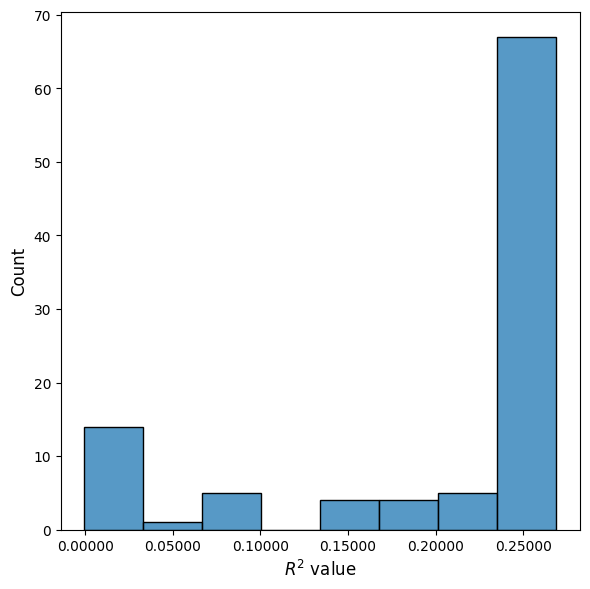

In [37]:
ax = sns.histplot(trials_df['value'])
ticks = ax.get_xticks()
ax.set_xticklabels(['{:.5f}'.format(t) for t in ticks])
ax.set_xlabel(r'$R^2$ value')
plt.tight_layout()

In [38]:
from plotly.io import show

fig = optuna.visualization.plot_optimization_history(study)
show(fig)

In [41]:
fig = optuna.visualization.plot_contour(study, params=["alpha", "l1_ratio"])
show(fig)

In [42]:
fig = optuna.visualization.plot_slice(study, params=["alpha", "l1_ratio"])
show(fig)

In [43]:
fig = optuna.visualization.plot_parallel_coordinate(
    study, params=["alpha", "l1_ratio"])
show(fig)

In [44]:
fig = optuna.visualization.plot_param_importances(study)
show(fig)

In [45]:
regressor = ElasticNet(**best_params)
elastic_net_pipe = Pipeline([('vect', vect), ('reg', regressor)])
elastic_net_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = elastic_net_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.1908110436729366

In [46]:
predicted_coords = elastic_net_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'ElasticNet', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.3688078624635172 2.77494427947792
2.9397463034364146 14.319101787090485


### KNN

In [47]:
def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                    weights=weights, 
                                    p=p)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-08 12:01:37,177] A new study created in memory with name: no-name-266b1a82-6c3c-400e-b213-c0fe9a22ba9f
[I 2024-11-08 12:01:38,735] Trial 0 finished with value: -0.010028604078177262 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: -0.010028604078177262.
[I 2024-11-08 12:01:39,501] Trial 1 finished with value: -0.79292135801679 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: -0.010028604078177262.
[I 2024-11-08 12:01:40,295] Trial 2 finished with value: -4.0084945594365265e-05 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: -4.0084945594365265e-05.
[I 2024-11-08 12:01:40,882] Trial 3 finished with value: 0.007394850275979503 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.007394850275979503.
[I 2024-11-08 12:01:41,164] Trial 4 finished with value: 0.05683979552510965 and parameters: {'n_ne

In [48]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.05683979552510965
best trial: FrozenTrial(number=4, state=1, values=[0.05683979552510965], datetime_start=datetime.datetime(2024, 11, 8, 12, 1, 40, 883362), datetime_complete=datetime.datetime(2024, 11, 8, 12, 1, 41, 164375), params={'n_neighbors': 20, 'weights': 'uniform', 'p': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=50, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2))}, trial_id=4, value=None)
best params: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}


In [49]:
regressor = KNeighborsRegressor(**best_params)
knr_pipe = Pipeline([('vect', vect), ('reg', regressor)])
knr_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = knr_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.07013869024375446

In [50]:
predicted_coords = knr_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'KNeighborsRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.4724193533739125 3.1334937826661555
3.341906123689139 16.64588229495783


### Random Forest

In [51]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    regressor = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-08 12:02:18,648] A new study created in memory with name: no-name-df6e0a94-1063-4bc2-8cc3-8bc3df1b6a07
[I 2024-11-08 12:02:20,155] Trial 0 finished with value: 0.09231698919997056 and parameters: {'n_estimators': 298, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.09231698919997056.
[I 2024-11-08 12:02:20,543] Trial 1 finished with value: 0.06229302239495536 and parameters: {'n_estimators': 153, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.09231698919997056.
[I 2024-11-08 12:02:20,972] Trial 2 finished with value: 0.0799030094448058 and parameters: {'n_estimators': 136, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.09231698919997056.
[I 2024-11-08 12:02:24,775] Trial 3 finished with value: 0.1010146608018394 and parameters: {'n_estimators': 396, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with 

In [52]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.10723363921173794
best trial: FrozenTrial(number=86, state=1, values=[0.10723363921173794], datetime_start=datetime.datetime(2024, 11, 8, 12, 6, 0, 533194), datetime_complete=datetime.datetime(2024, 11, 8, 12, 6, 4, 604943), params={'n_estimators': 329, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=86, value=None)
best params: {'n_estimators': 329, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 5}


In [53]:
regressor = RandomForestRegressor(**best_params)
random_forest_pipe = Pipeline([('vect', vect), ('reg', regressor)])
random_forest_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = random_forest_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.14826740342887162

In [54]:
predicted_coords = random_forest_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'RandomForestRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.426737105035292 2.8259611519989307
3.151511407152797 218.1461476522387


### Extremely Randomized Trees

In [55]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    regressor = ExtraTreesRegressor(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-08 12:13:23,395] A new study created in memory with name: no-name-7eeb5b01-daa7-4520-bf34-6e0013f8929b
[I 2024-11-08 12:13:26,542] Trial 0 finished with value: 0.10358598680641037 and parameters: {'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.10358598680641037.
[I 2024-11-08 12:13:27,813] Trial 1 finished with value: 0.09623682676146111 and parameters: {'n_estimators': 169, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.10358598680641037.
[I 2024-11-08 12:13:28,593] Trial 2 finished with value: 0.08641951152549635 and parameters: {'n_estimators': 285, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.10358598680641037.
[I 2024-11-08 12:13:29,670] Trial 3 finished with value: 0.10065379931464377 and parameters: {'n_estimators': 206, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with

In [56]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.10614224761780011
best trial: FrozenTrial(number=10, state=1, values=[0.10614224761780011], datetime_start=datetime.datetime(2024, 11, 8, 12, 13, 35, 332636), datetime_complete=datetime.datetime(2024, 11, 8, 12, 13, 37, 23374), params={'n_estimators': 355, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=10, value=None)
best params: {'n_estimators': 355, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 10}


In [57]:
regressor = ExtraTreesRegressor(**best_params)
extra_trees_pipe = Pipeline([('vect', vect), ('reg', regressor)])
extra_trees_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = extra_trees_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.15216556377808432

In [58]:
predicted_coords = extra_trees_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (mean_squared_error(test.lat.values, predicted_coords[:, 0]),
                    mean_squared_error(test.lon.values, predicted_coords[:, 1]))

optimization_results.append([
    'ExtraTreesRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.4317985824673702 2.841355155790526
3.1450439656439566 14.660148654868678


In [59]:
columns = [
    'regressor',
    'cv_score',
    'test_score',
    'best_params',
    'mae_lat', 
    'mae_lon',
    'mse_lat',
    'mse_lon'
]

optimization_results_df = pd.DataFrame(optimization_results, columns=columns)
optimization_results_df

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon
0,LinearRegression,0.110662,0.171430,None,1.380435,2.804612,3.003500,14.697231
1,ElasticNet,0.268893,0.190811,"{'alpha': 0.00018042699413294217, 'l1_ratio': ...",1.368808,2.774944,2.939746,14.319102
2,KNeighborsRegressor,0.056840,0.070139,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 2}",1.472419,3.133494,3.341906,16.645882
3,RandomForestRegressor,0.107234,0.148267,"{'n_estimators': 329, 'max_depth': 32, 'min_sa...",1.426737,2.825961,3.151511,218.146148
4,ExtraTreesRegressor,0.106142,0.152166,"{'n_estimators': 355, 'max_depth': 32, 'min_sa...",1.431799,2.841355,3.145044,14.660149


In [60]:
optimization_results_df['mae_avg'] = optimization_results_df[['mae_lat', 'mae_lon']].mean(axis=1)
optimization_results_df['mse_avg'] = optimization_results_df[['mse_lat', 'mse_lon']].mean(axis=1)
optimization_results_df

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon,mae_avg,mse_avg
0,LinearRegression,0.110662,0.171430,None,1.380435,2.804612,3.003500,14.697231,2.092524,8.850365
1,ElasticNet,0.268893,0.190811,"{'alpha': 0.00018042699413294217, 'l1_ratio': ...",1.368808,2.774944,2.939746,14.319102,2.071876,8.629424
2,KNeighborsRegressor,0.056840,0.070139,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 2}",1.472419,3.133494,3.341906,16.645882,2.302957,9.993894
3,RandomForestRegressor,0.107234,0.148267,"{'n_estimators': 329, 'max_depth': 32, 'min_sa...",1.426737,2.825961,3.151511,218.146148,2.126349,110.648830
4,ExtraTreesRegressor,0.106142,0.152166,"{'n_estimators': 355, 'max_depth': 32, 'min_sa...",1.431799,2.841355,3.145044,14.660149,2.136577,8.902596


In [61]:
optimization_results_df.round({
    'mae_lat':2, 
    'mae_lon': 2, 
    'mse_lat': 2, 
    'mse_lon': 2,
    'mae_avg': 2,
    'mse_avg': 2
})

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon,mae_avg,mse_avg
0,LinearRegression,0.110662,0.171430,None,1.38,2.80,3.00,14.70,2.09,8.85
1,ElasticNet,0.268893,0.190811,"{'alpha': 0.00018042699413294217, 'l1_ratio': ...",1.37,2.77,2.94,14.32,2.07,8.63
2,KNeighborsRegressor,0.056840,0.070139,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 2}",1.47,3.13,3.34,16.65,2.30,9.99
3,RandomForestRegressor,0.107234,0.148267,"{'n_estimators': 329, 'max_depth': 32, 'min_sa...",1.43,2.83,3.15,218.15,2.13,110.65
4,ExtraTreesRegressor,0.106142,0.152166,"{'n_estimators': 355, 'max_depth': 32, 'min_sa...",1.43,2.84,3.15,14.66,2.14,8.90


* Having arrived at this point, it is worth pointing out that the $\alpha$ parameter of `ElasticNet` is very small:

In [62]:
optimization_results_df[optimization_results_df.regressor == 'ElasticNet']['best_params']

1    {'alpha': 0.00018042699413294217, 'l1_ratio': ...
Name: best_params, dtype: object

* That means that in practice `ElasticNet` behaves pretty much like Ordinary Least Squares regression.

## Finding terms pushing North, South, West, and East

In [63]:
importance_pd = pd.DataFrame({"feature": elastic_net_pipe["vect"].get_feature_names_out(), 
                              "lat": elastic_net_pipe["reg"].coef_[0, :],
                              "lon": elastic_net_pipe["reg"].coef_[1, :]})

### Words pushing $\uparrow$ North: higher lat

In [64]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
692,τρώγει,2.816958,-0.270769
552,πε,2.542493,-0.544727
96,ατ,2.486340,12.515086
631,σον,2.467518,12.119237
195,διάβολο,2.333480,-0.548818


### Words pushing $\downarrow$ South: lower lat

In [65]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
660,τζ,-4.542606,8.661964
662,τζαι,-4.240746,8.170965
661,τζαί,-4.219113,8.056187
664,τζι,-3.715953,7.479924
226,εγιώ,-3.085034,2.284832


### Words pushing $\rightarrow$ East: higher lon

In [66]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
96,ατ,2.486340,12.515086
631,σον,2.467518,12.119237
630,σο,2.127457,12.115307
616,ση,2.125758,10.962153
386,λύκον,1.218937,9.700139


### Words pushing $\leftarrow$ West: higher lon

In [67]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
157,γελάει,-0.092617,-4.882684
501,ου,0.673268,-4.676683
466,ναν,0.373891,-4.657131
107,αφέντη,0.123901,-4.159472
125,βλάχος,0.135415,-4.095337
